We check here to see if 
* there is correlation between price **'valeur_fonciere'** and the GPS coordinates ('longitude' + 'latitude')
* there is correlation between price **'prixmetre'** and the GPS coordinates ('longitude' + 'latitude')


**Conclusion : no significant result**


In [63]:
#Imports 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import namedtuple

# Get and Filter data


In [64]:
#Load Libraries and Create engine Connection

import pymysql
import pandas as pd
import numpy as np
import sqlalchemy
import gc
engine =sqlalchemy.create_engine(
        sqlalchemy.engine.url.URL.create(
        drivername="mysql+pymysql",
        username='Estimators',  # e.g. "my-database-user"
        password='Estimator2021',  # e.g. "my-database-password"
        host='34.77.88.127',  # e.g. "127.0.0.1"
        port=3306,  # e.g. 3306
        database='Housing_France',  # e.g. "my-database-name"
    ))

conn = engine.connect().execution_options(stream_results=True)

In [65]:
#Load Libraries and Create engine Connection

import pymysql
import pandas as pd
import numpy as np
import sqlalchemy
import gc

def get_data(querystring,chunk):
    engine =sqlalchemy.create_engine(
    sqlalchemy.engine.url.URL.create(
    drivername="mysql+pymysql",
    username='Estimators',  # e.g. "my-database-user"
    password='Estimator2021',  # e.g. "my-database-password"
    host='34.77.88.127',  # e.g. "127.0.0.1"
    port=3306,  # e.g. 3306
    database='Housing_France',  # e.g. "my-database-name"
    ))
    conn = engine.connect().execution_options(stream_results=True)
    frame = pd.DataFrame()
    for chunk_dataframe in pd.read_sql(
            querystring, conn, chunksize=chunk):
            print(f"Got dataframe w/{len(chunk_dataframe)} rows")
            frame= frame.append(chunk_dataframe)
            # ... do something with dataframe ...
            
    return frame

In [66]:
#Template for getting some data
df = get_data("""select * from data_working_update LIMIT 500000""", 10000)

Got dataframe w/10000 rows
Got dataframe w/10000 rows
Got dataframe w/10000 rows
Got dataframe w/10000 rows
Got dataframe w/10000 rows
Got dataframe w/10000 rows
Got dataframe w/10000 rows
Got dataframe w/10000 rows
Got dataframe w/10000 rows
Got dataframe w/10000 rows
Got dataframe w/10000 rows
Got dataframe w/10000 rows
Got dataframe w/10000 rows
Got dataframe w/10000 rows
Got dataframe w/10000 rows
Got dataframe w/10000 rows
Got dataframe w/10000 rows
Got dataframe w/10000 rows
Got dataframe w/10000 rows
Got dataframe w/10000 rows
Got dataframe w/10000 rows
Got dataframe w/10000 rows
Got dataframe w/10000 rows
Got dataframe w/10000 rows
Got dataframe w/10000 rows
Got dataframe w/10000 rows
Got dataframe w/10000 rows
Got dataframe w/10000 rows
Got dataframe w/10000 rows
Got dataframe w/10000 rows
Got dataframe w/10000 rows
Got dataframe w/10000 rows
Got dataframe w/10000 rows
Got dataframe w/10000 rows
Got dataframe w/10000 rows
Got dataframe w/10000 rows
Got dataframe w/10000 rows
G

Make copy

In [67]:
data = df.copy()
data.columns

Index(['id_mutation', 'date_mutation', 'nature_mutation', 'valeur_fonciere',
       'adresse_suffixe', 'adresse_nom_voie', 'adresse_code_voie',
       'code_postal', 'code_commune', 'nom_commune', 'code_departement',
       'ancien_code_commune', 'ancien_nom_commune', 'id_parcelle',
       'ancien_id_parcelle', 'lot1_numero', 'lot1_surface_carrez',
       'lot2_numero', 'lot2_surface_carrez', 'lot3_numero',
       'lot3_surface_carrez', 'lot4_numero', 'lot4_surface_carrez',
       'lot5_numero', 'lot5_surface_carrez', 'nombre_lots', 'code_type_local',
       'type_local', 'surface_reelle_bati', 'nombre_pieces_principales',
       'code_nature_culture', 'nature_culture', 'code_nature_culture_speciale',
       'nature_culture_speciale', 'surface_terrain', 'longitude', 'latitude'],
      dtype='object')

In [68]:
data.shape

(500000, 37)

# Sum of longitude and latitude  , add prixmetre

In [69]:
# sum two columns : longitude &latitude

sum_column = data.loc[:, "longitude"] + data.loc[:, "latitude"]
data.loc[:, "coordonnees_GPS"] = sum_column

prixmetr = data['valeur_fonciere'].values / data['surface_reelle_bati'].values
data.loc[:,'prixmetre'] = prixmetr

data.head(2)

,id_mutation,date_mutation,nature_mutation,valeur_fonciere,adresse_suffixe,adresse_nom_voie,adresse_code_voie,code_postal,code_commune,nom_commune,...,nombre_pieces_principales,code_nature_culture,nature_culture,code_nature_culture_speciale,nature_culture_speciale,surface_terrain,longitude,latitude,coordonnees_GPS,prixmetre
0,2016-1,2016-01-08,Vente,40000,,RUE TONY REVILLON,0560,1750,1370,Saint-Laurent-sur-Saône,...,2,,,,,0,4.840606,46.304486,51.145092,800.0
1,2016-4,2016-01-08,Vente,90000,,PELUS,B203,1560,1364,Saint-Jean-sur-Reyssouze,...,6,S,sols,,,1220,5.059020,46.386697,51.445717,600.0


## Column : valeur_fonciere

In [70]:
data['valeur_fonciere'].unique()

array([ 40000,  90000, 203700, ...,  19672,  76530, 356775])

In [71]:
data['valeur_fonciere'].value_counts()

100000    6834
150000    6670
120000    6475
110000    6002
130000    5839
          ... 
115230       1
145913       1
128601       1
194452       1
356775       1
Name: valeur_fonciere, Length: 33432, dtype: int64

###Missing values

In [72]:
data['valeur_fonciere'].isnull().sum()

0

# Select rows with NaN in 'valeur_fonciere'

Check if there are NaN in column 'surface_terrain'

In [73]:
def select_rows_with_nan_in_list_columns(df, col_name): #df : dataframe
    if len(col_name) == 1 :
        selected_rows = df[
                     df[col_name[0]].isnull() 
                     ]
    elif len(col_name) > 1:
        selected_rows = df[
                     df[col_name[0]].isnull() & \
                     df[col_name[1]].isnull() 
                     ]
    return selected_rows


df_test = select_rows_with_nan_in_list_columns(df = data,
                                         col_name= ['valeur_fonciere'])
df_test.shape


(0, 39)

In [74]:
len(data) - len(df_test) 

500000

In [76]:
mask_columns = ['id_mutation', 'date_mutation', 
                 'nature_mutation', 
       'surface_terrain', 'surface_reelle_bati',
                'nombre_lots', 
                'valeur_fonciere', 'prixmetre']

df_test[mask_columns]

,id_mutation,date_mutation,nature_mutation,surface_terrain,surface_reelle_bati,nombre_lots,valeur_fonciere,prixmetre


# Drop rows with NaN in 'valeur_fonciere'

In [77]:
def drop_rows_with_nan_in_list_columns(df, col_name): #df : dataframe

    mod_df = df.dropna( how='all', subset=col_name)
  
    return mod_df


clean_data = drop_rows_with_nan_in_list_columns(df = data,
                          col_name= ['valeur_fonciere'])

clean_data.shape


(500000, 39)

In [78]:

mask_columns = ['id_mutation', 'date_mutation', 
                 'nature_mutation', 
       'surface_terrain', 'surface_reelle_bati',
                'nombre_lots', 'longitude',
                'latitude', 'coordonnees_GPS',
                'valeur_fonciere', 'prixmetre']

clean_data[mask_columns]

,id_mutation,date_mutation,nature_mutation,surface_terrain,surface_reelle_bati,nombre_lots,longitude,latitude,coordonnees_GPS,valeur_fonciere,prixmetre
0,2016-1,2016-01-08,Vente,0,50,1,4.840606,46.304486,51.145092,40000,800.000000
1,2016-4,2016-01-08,Vente,1220,150,0,5.059020,46.386697,51.445717,90000,600.000000
2,2016-6,2016-01-04,Vente,500,98,0,4.996678,46.383446,51.380124,203700,2078.571429
3,2016-6,2016-01-04,Vente,750,98,0,4.996678,46.383446,51.380124,203700,2078.571429
4,2016-7,2016-01-09,Vente,464,70,0,5.161898,46.290693,51.452591,147000,2100.000000
...,...,...,...,...,...,...,...,...,...,...,...
9995,2016-670914,2016-12-05,Vente,628,110,0,-2.657281,47.626416,44.969135,320000,2909.090909
9996,2016-670917,2016-12-13,Vente,0,29,1,-2.752601,47.658392,44.905791,50000,1724.137931
9997,2016-670918,2016-11-23,Vente,500,82,0,-2.904072,47.544271,44.640199,232000,2829.268293
9998,2016-670919,2016-12-09,Vente,2840,108,0,-2.132096,47.752898,45.620802,118000,1092.592593


In [79]:
df_new = clean_data.drop_duplicates()
df_new[mask_columns]

,id_mutation,date_mutation,nature_mutation,surface_terrain,surface_reelle_bati,nombre_lots,longitude,latitude,coordonnees_GPS,valeur_fonciere,prixmetre
0,2016-1,2016-01-08,Vente,0,50,1,4.840606,46.304486,51.145092,40000,800.000000
1,2016-4,2016-01-08,Vente,1220,150,0,5.059020,46.386697,51.445717,90000,600.000000
2,2016-6,2016-01-04,Vente,500,98,0,4.996678,46.383446,51.380124,203700,2078.571429
3,2016-6,2016-01-04,Vente,750,98,0,4.996678,46.383446,51.380124,203700,2078.571429
4,2016-7,2016-01-09,Vente,464,70,0,5.161898,46.290693,51.452591,147000,2100.000000
...,...,...,...,...,...,...,...,...,...,...,...
9995,2016-670914,2016-12-05,Vente,628,110,0,-2.657281,47.626416,44.969135,320000,2909.090909
9996,2016-670917,2016-12-13,Vente,0,29,1,-2.752601,47.658392,44.905791,50000,1724.137931
9997,2016-670918,2016-11-23,Vente,500,82,0,-2.904072,47.544271,44.640199,232000,2829.268293
9998,2016-670919,2016-12-09,Vente,2840,108,0,-2.132096,47.752898,45.620802,118000,1092.592593


In [80]:
df_test = df_new[df_new['id_mutation'] == '2016-670919']
df_test['surface_reelle_bati'].sum()

216

In [81]:
df_test.shape

(2, 39)

In [82]:
df_test

,id_mutation,date_mutation,nature_mutation,valeur_fonciere,adresse_suffixe,adresse_nom_voie,adresse_code_voie,code_postal,code_commune,nom_commune,...,nombre_pieces_principales,code_nature_culture,nature_culture,code_nature_culture_speciale,nature_culture_speciale,surface_terrain,longitude,latitude,coordonnees_GPS,prixmetre
9998,2016-670919,2016-12-09,Vente,118000,,RUE DE LA CHEVEE,0008,56200,56044,Cournon,...,4,T,terres,,,2840,-2.132096,47.752898,45.620802,1092.592593
9999,2016-670919,2016-12-09,Vente,118000,,RUE DE LA CHEVEE,0008,56200,56044,Cournon,...,4,S,sols,,,800,-2.132096,47.752898,45.620802,1092.592593


In [83]:
df_new.shape

(488622, 39)

In [84]:
df_new.head(2)

,id_mutation,date_mutation,nature_mutation,valeur_fonciere,adresse_suffixe,adresse_nom_voie,adresse_code_voie,code_postal,code_commune,nom_commune,...,nombre_pieces_principales,code_nature_culture,nature_culture,code_nature_culture_speciale,nature_culture_speciale,surface_terrain,longitude,latitude,coordonnees_GPS,prixmetre
0,2016-1,2016-01-08,Vente,40000,,RUE TONY REVILLON,0560,1750,1370,Saint-Laurent-sur-Saône,...,2,,,,,0,4.840606,46.304486,51.145092,800.0
1,2016-4,2016-01-08,Vente,90000,,PELUS,B203,1560,1364,Saint-Jean-sur-Reyssouze,...,6,S,sols,,,1220,5.059020,46.386697,51.445717,600.0


# Fill numeric and nonnumeric nulls 

In [85]:
mask_columns = ['id_mutation', 'date_mutation', 
                 'nature_mutation', 
       'surface_terrain', 'surface_reelle_bati',
                'nombre_lots', 'longitude',
                'latitude', 'coordonnees_GPS',
                'valeur_fonciere', 'prixmetre']

dfn = df_new[mask_columns]
dfn.shape

(488622, 11)

In [86]:
dfn.columns

Index(['id_mutation', 'date_mutation', 'nature_mutation', 'surface_terrain',
       'surface_reelle_bati', 'nombre_lots', 'longitude', 'latitude',
       'coordonnees_GPS', 'valeur_fonciere', 'prixmetre'],
      dtype='object')

In [87]:
#created a function to fill numeric and nonnumeric nulls with either their mean or mode.

def fill_na_with_mean_or_mode(col):
    if col.dtype == int or col.dtype == float:
        return col.fillna(round(col.mean()), inplace=True)
    else:
        return col.fillna(col.mode()[0], inplace=True)

#for col in list(dfn.columns):
 #   fill_na_with_mean_or_mode(dfn[col])

In [88]:
def confirm_no_any_null_vals(df):
    L = df[df.columns[df.isnull().any()]].isnull().sum()
    if len(L) == 0:
        print('There are no longer any null values')
    else :
        print('Warning ! Null values still exist ')
    return True if len(L)==0 else False

confirm_no_any_null_vals(dfn)

There are no longer any null values


True

In [89]:
#check there were no instances where sale price was less than 0€

def confirm_no_negative_val_fonciere(df):
    L = df[df['valeur_fonciere'] < 0]
    if len(L) == 0:
        print('There were no mutations where sale price was less than 0€')
    else :
        print('Warning ! Negative sale price exist ')
    return True if len(L)==0 else False

confirm_no_negative_val_fonciere(dfn)

There were no mutations where sale price was less than 0€


True

In [90]:
def get_count_val_fonciere_equal_1(df):
    L = df[df['valeur_fonciere'] ==1]
  
    return len(L)

get_count_val_fonciere_equal_1(dfn)

0

In [91]:
def get_count_val_fonciere_less_than_1(df):
    L = df[df['valeur_fonciere'] < 1]
  
    return len(L)

get_count_val_fonciere_less_than_1(dfn)

0

# Visualize the distribution of the target variable / or other feature

/Users/kenzaelhoussaini/.pyenv/versions/3.8.6/envs/reestimator/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


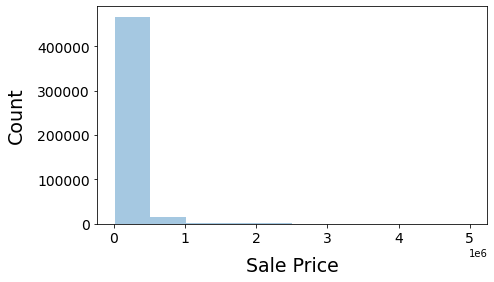

In [92]:
#looking at the distribution of the target variable : valeur_fonciere 
# or any column
def visualize_distribution_column(df, col_name, labelx): #labelx : string 
                                                  #to describe x-axis
    fig, ax = plt.subplots(figsize = (7, 4))
    sns.distplot(df[col_name], kde=False, bins=10)

    plt.xlabel(labelx, fontsize=19, labelpad=11)
    plt.xticks(fontsize=14)
    plt.ylabel('Count', fontsize=19, labelpad=11)
    plt.yticks(fontsize=14);

visualize_distribution_column(df = dfn, 
                              col_name='valeur_fonciere',labelx = 'Sale Price')



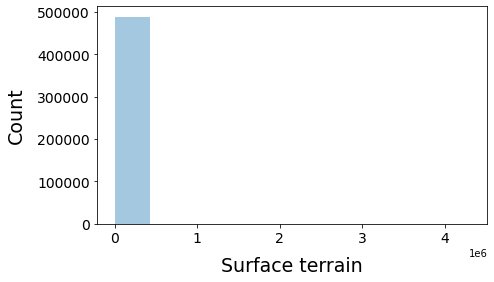

In [93]:
#looking at the distribution of the column :surface_terrain 

visualize_distribution_column(df = dfn, 
                              col_name='surface_terrain',
                              labelx = 'Surface terrain')

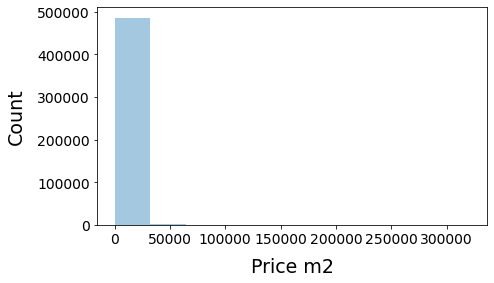

In [94]:
visualize_distribution_column(df = dfn, 
                              col_name='prixmetre',
                              labelx = 'Price m2')



# Visualize the log distribution of the target variable / or other feature

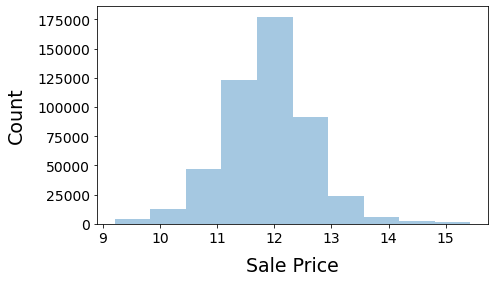

In [95]:
#looking at the log distribution of the target variable : valeur_fonciere 
# or any column
def visualize_log_distribution_column(df, col_name, labelx): #labelx : string 
                                                  #to describe x-axis
    fig, ax = plt.subplots(figsize = (7, 4))
    sns.distplot(np.log(df[col_name]), kde=False, bins=10)

    plt.xlabel(labelx, fontsize=19, labelpad=11)
    plt.xticks(fontsize=14)
    plt.ylabel('Count', fontsize=19, labelpad=11)
    plt.yticks(fontsize=14);

visualize_log_distribution_column(df = dfn, 
                              col_name='valeur_fonciere',labelx = 'Sale Price')

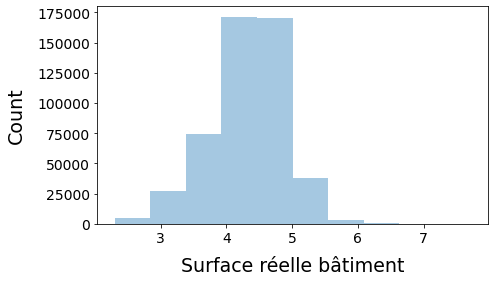

In [96]:
#looking at the log distribution of the column :surface_reelle_bati

visualize_log_distribution_column(df = dfn, 
                              col_name='surface_reelle_bati',
                              labelx = 'Surface réelle bâtiment')

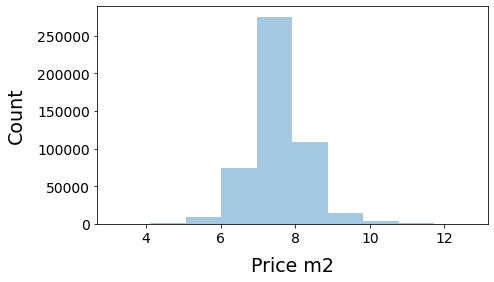

In [101]:
visualize_log_distribution_column(df = dfn, 
                            col_name='prixmetre',
                              labelx = 'Price m2')

# Get summary stats

In [102]:
#getting summary stats on column 

def get_summary_stats(df, col_name):
    return df[col_name].describe()

In [103]:
def get_summary_stats_log(df, col_name):
    return np.log(df[col_name]).describe()

In [104]:
#summary stats on target variable 'valeur_fonciere'
get_summary_stats(df= dfn, col_name = 'valeur_fonciere')

count    4.886220e+05
mean     2.004853e+05
std      2.625965e+05
min      1.000000e+04
25%      9.100000e+04
50%      1.490000e+05
75%      2.256000e+05
max      5.000000e+06
Name: valeur_fonciere, dtype: float64

In [105]:
res = get_summary_stats(df= dfn, col_name = 'valeur_fonciere')

In [106]:
res['min'], res['max']

(10000.0, 5000000.0)

In [107]:
#summary stats on column 'surface_terrain'
get_summary_stats(df= dfn, col_name = 'surface_terrain')

count    4.886220e+05
mean     6.383951e+02
std      1.095674e+04
min      0.000000e+00
25%      0.000000e+00
50%      2.830000e+02
75%      6.800000e+02
max      4.301668e+06
Name: surface_terrain, dtype: float64

In [108]:
#summary stats on target variable 'valeur_fonciere'
res_log = get_summary_stats_log(df= dfn, col_name = 'valeur_fonciere')

In [109]:
res_log['min'], res_log['max']

(9.210340371976184, 15.424948470398375)

#  Correlation

#Corelations with target column : valeur_fonciere

In [110]:
# Here, We use whole data df, to look at correlation between variable target and all other features

def get_correlation_features_targetVar(df, target_var):
    df_corr = df.corr()[[target_var]].sort_values(target_var, ascending=False)
    return df_corr

df_corr = get_correlation_features_targetVar(df = df_new, target_var = 'prixmetre')
df_corr.head(5)

,prixmetre
prixmetre,1.000000
valeur_fonciere,0.749932
code_type_local,0.168600
longitude,0.065168
surface_terrain,0.047775


In [111]:
df_log = df_new.copy()
df_log['valeur_fonciere']= np.log(df_new['valeur_fonciere'])
df_log['prixmetre']= np.log(df_new['prixmetre'])
df_log = df_log.rename(columns={"valeur_fonciere": "log(valeur_fonciere)", 
                               "prixmetre" : "log(prixmetre)" })
df_log.head(3)

,id_mutation,date_mutation,nature_mutation,log(valeur_fonciere),adresse_suffixe,adresse_nom_voie,adresse_code_voie,code_postal,code_commune,nom_commune,...,nombre_pieces_principales,code_nature_culture,nature_culture,code_nature_culture_speciale,nature_culture_speciale,surface_terrain,longitude,latitude,coordonnees_GPS,log(prixmetre)
0,2016-1,2016-01-08,Vente,10.596635,,RUE TONY REVILLON,0560,1750,1370,Saint-Laurent-sur-Saône,...,2,,,,,0,4.840606,46.304486,51.145092,6.684612
1,2016-4,2016-01-08,Vente,11.407565,,PELUS,B203,1560,1364,Saint-Jean-sur-Reyssouze,...,6,S,sols,,,1220,5.059020,46.386697,51.445717,6.396930
2,2016-6,2016-01-04,Vente,12.224404,,AU BOURG,B014,1190,1050,Boissey,...,4,S,sols,,,500,4.996678,46.383446,51.380124,7.639436


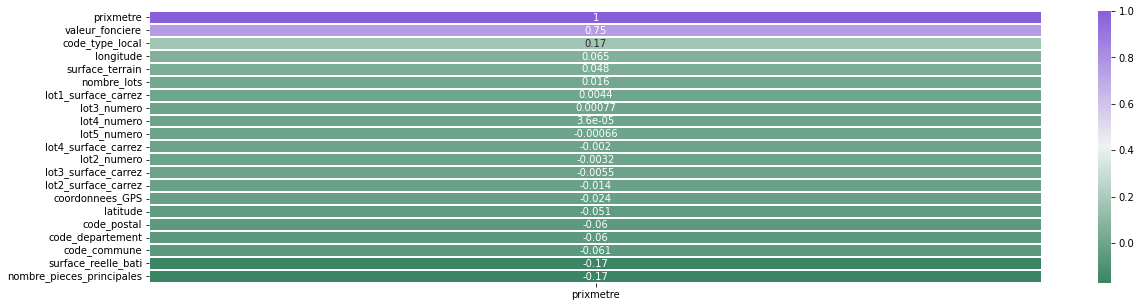

In [112]:
def plot_correlation_heatmap(df, target_var): #df : correlation dataframe
    df = df.dropna()
    fig, ax = plt.subplots(figsize = (20, 5))

    cmap = sns.diverging_palette(150, 275, as_cmap=True)
    sns.heatmap(df, annot=True, linewidths=.4, cmap=cmap, ax=ax);


plot_correlation_heatmap(df = df_corr, target_var = 'prixmetre')

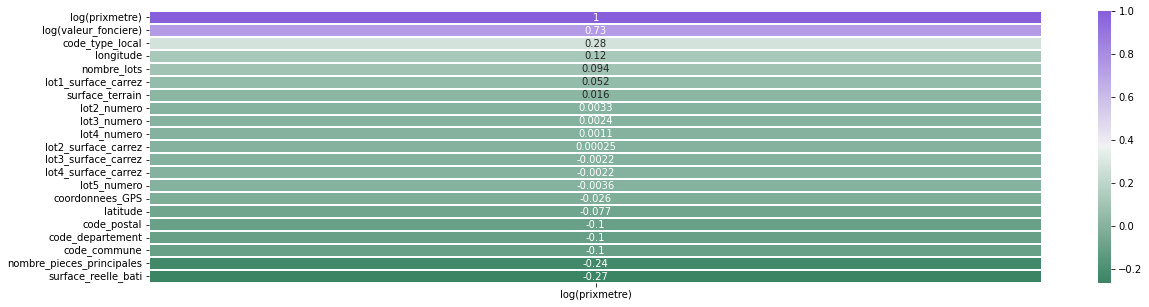

In [113]:
df_corr_log = get_correlation_features_targetVar(df = df_log, target_var = 'log(prixmetre)')

plot_correlation_heatmap(df = df_corr_log, target_var = 'log(prixmetre)')

# Scatterplots

## surface_reelle_bati

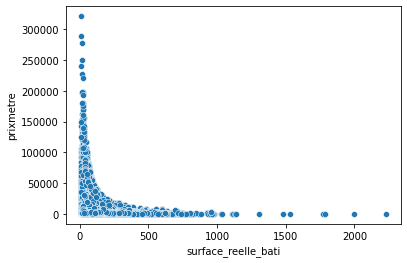

In [115]:
sns.scatterplot(x=df_new['surface_reelle_bati'], y=df_new['prixmetre']);

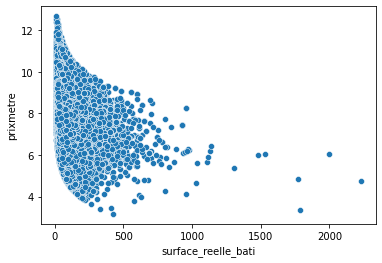

In [116]:
sns.scatterplot(x=df_new['surface_reelle_bati'], y=np.log(df_new['prixmetre']));

## nombre_pieces_principales

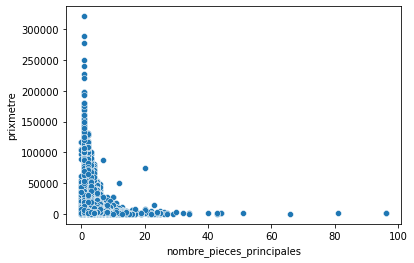

In [117]:
sns.scatterplot(x=df_new['nombre_pieces_principales'], y=df_new['prixmetre']);

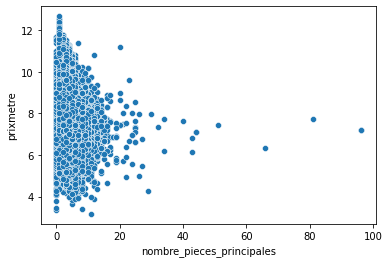

In [118]:
sns.scatterplot(x=df_new['nombre_pieces_principales'], y=np.log(df_new['prixmetre']));

## nombre_lots

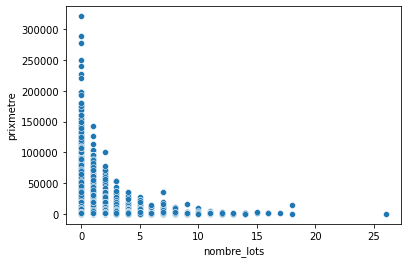

In [119]:
sns.scatterplot(x=df_new['nombre_lots'], y=df_new['prixmetre']);

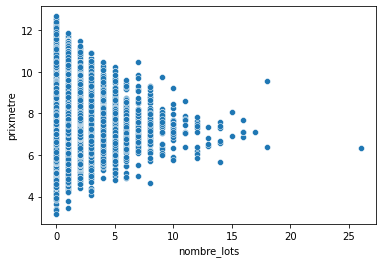

In [120]:
sns.scatterplot(x=df_new['nombre_lots'], y=np.log(df_new['prixmetre']));

## lot4_numero

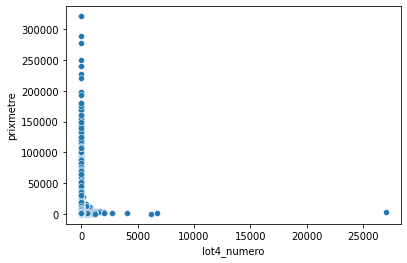

In [121]:
sns.scatterplot(x=(df_new['lot4_numero']).dropna(), y=df_new['prixmetre']);

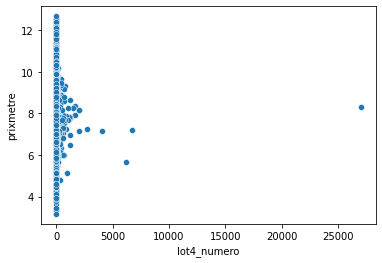

In [122]:
sns.scatterplot(x=(df_new['lot4_numero']).dropna(), y=np.log(df_new['prixmetre']));

## code_postal

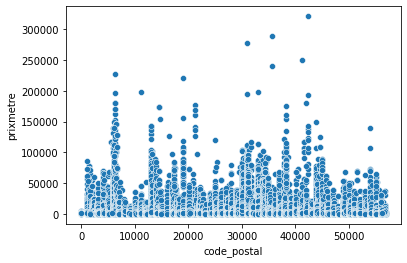

In [123]:
sns.scatterplot(x=df_new['code_postal'], y=df_new['prixmetre']);

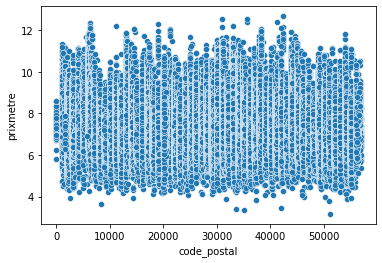

In [124]:
sns.scatterplot(x=df_new['code_postal'], y=np.log(df_new['prixmetre']));

##  code_type_local

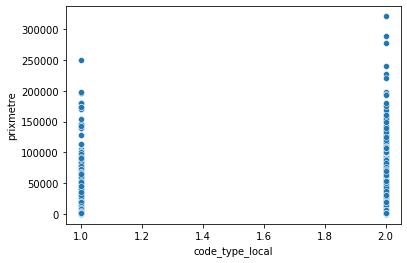

In [131]:
sns.scatterplot(x=df_new['code_type_local'], y=df_new['prixmetre']);

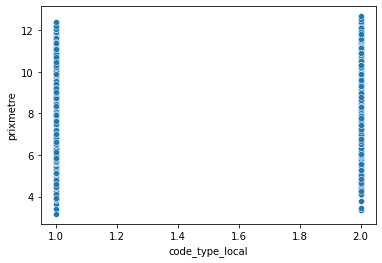

In [126]:
sns.scatterplot(x=(df_new['code_type_local']).dropna(), y=np.log(df_new['prixmetre']));

##  Coordonnées GPS

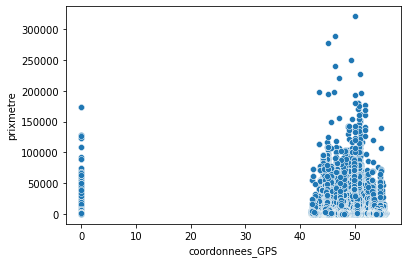

In [130]:
sns.scatterplot(x=df_new['coordonnees_GPS'], y=df_new['prixmetre']);

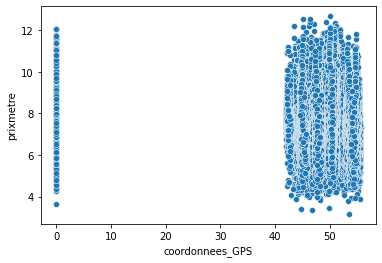

In [128]:
sns.scatterplot(x=(df_new['coordonnees_GPS']).dropna(), y=np.log(df_new['prixmetre']));

## longitude

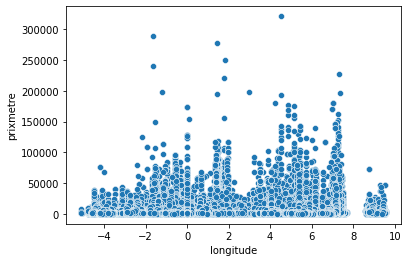

In [132]:
sns.scatterplot(x=df_new['longitude'], y=df_new['prixmetre']);

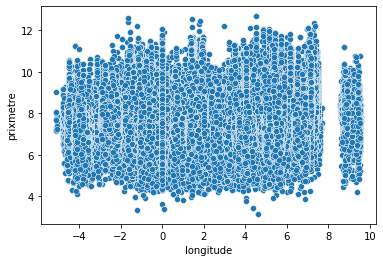

In [129]:
sns.scatterplot(x=(df_new['longitude']).dropna(), y=np.log(df_new['prixmetre']));